# Build a Traffic Sign Recognition Classifier

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import os
import glob
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
import cv2
from keras.preprocessing.image import ImageDataGenerator
from random import randint
from sklearn.model_selection import KFold

Using TensorFlow backend.


In [2]:
def preprocess(X):
    rgb2gray = [0.299, 0.587, 0.114]
    # Convert images to grayscale
    X_gray = np.dot(X[...,:3], rgb2gray)

    # Normalize images
    X_gray = (X_gray/255-0.5)*2
    X_gray = X_gray.reshape(*X_gray.shape, 1)
    return X_gray

In [3]:
train_dir = "Bottle-Classifier/training_data/"
data = pd.read_csv(train_dir + "label.csv")
image_size = (96,96)

X_data = []
Y_data = []
for i in range(len(data)):
    filename = data.iloc[i,0]
    label = data.iloc[i,2]
    img = plt.imread(train_dir + filename)
    img = cv2.resize(img, image_size, interpolation=cv2.INTER_CUBIC)
    X_data.append(img)
    Y_data.append(label)

X_data = np.array(X_data)
Y_data = np.array(Y_data)

X_data, Y_data = shuffle(X_data, Y_data)
split = int(round(len(data)*0.8))
train = np.arange(split)
valid = np.arange(split, len(data))
X_train, Y_train = X_data[train], Y_data[train]
X_valid, Y_valid = X_data[valid], Y_data[valid]

# filename = train_dir + "label.p"
# with open(filename, mode = 'rb') as f:
#     train = pickle.load(f)
# X_data, Y_data = train['Images'], train['labels']    
    
# X_data = np.array(X_data)
# Y_data = np.array(Y_data)
# for i in range(len(Y_data)):
#     if Y_data[i] == 'ovaltine':
#         Y_data[i] = 0
#     elif Y_data[i] == 'ginkgo':
#         Y_data[i] = 1
#     elif Y_data[i] == 'babydream':
#         Y_data[i] = 2
#     elif Y_data[i] == 'lavie':
#         Y_data[i] = 3

# print(Y_data)
n_classes = len(np.unique(Y_data))
X_train = preprocess(X_train)
X_valid = preprocess(X_valid)

In [4]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)

(58, 96, 96, 1)
(58,)
(15, 96, 96, 1)
(15,)


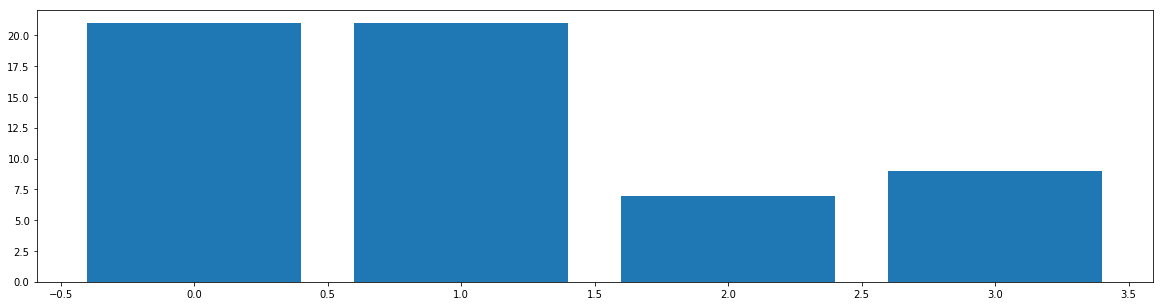

In [5]:
fig = plt.figure(figsize=(20,5))
classes = np.arange(n_classes)
count = np.bincount(Y_train)
plt.bar(classes,count)
plt.show()

In [6]:
# plt.figure(figsize=(30,15))
# i = 0
# for img in X_data:
#     i+=1
#     plt.subplot(1,len(X_data),i)
#     plt.imshow(img)        
                    
# plt.show()

# print(Y_data)

In [7]:
def dataAug(X_train, y_train):
    datagen = ImageDataGenerator(rotation_range=10,zoom_range=0.10)
    for x_batch, y_batch in datagen.flow(X_train, y_train, batch_size=X_train.shape[0], shuffle=False):
        X_train_aug = x_batch.astype('uint8')
        y_train_aug = y_batch
        break

    X_train = np.concatenate([X_train, X_train_aug])
    y_train = np.concatenate([y_train,y_train_aug])
    return X_train,y_train

In [16]:
#     LeNet: Input 96x96x1, 92x92x6, 46x46x6, 40x40x16, 20x20x16, 16x16x16,, 8x8x16, 1024, 512, 128, 32, n_classes
def LeNet(x):
    mu = 0
    sigma = 0.1
    weights = {
        'conv1_W' : tf.Variable(tf.truncated_normal(shape=(5,5,1,6), mean=mu, stddev=sigma), name='conv1_W'),
        'conv2_W' : tf.Variable(tf.truncated_normal(shape=(7,7,6,16), mean=mu, stddev=sigma), name='conv2_W'),
        'conv3_W' : tf.Variable(tf.truncated_normal(shape=(5,5,16,16), mean=mu, stddev=sigma), name='conv3_W'),
        'fc1_W' : tf.Variable(tf.truncated_normal(shape=(1024,512), mean=mu, stddev=sigma), name='fc1_W'),
        'fc2_W' : tf.Variable(tf.truncated_normal(shape=(512,128), mean=mu, stddev=sigma), name='fc2_W'),
        'fc3_W' : tf.Variable(tf.truncated_normal(shape=(128,32), mean=mu, stddev=sigma), name='fc3_W'),
        'fc4_W' : tf.Variable(tf.truncated_normal(shape=(32,n_classes), mean=mu, stddev=sigma), name='fc4_W')
    }

    w1 = tf.Variable(tf.random_normal(shape=[2]), name='w1')

    biases = {
        'conv1_b' : tf.Variable(tf.truncated_normal([6], mean=mu, stddev=sigma), 'conv1_b'),
        'conv2_b' : tf.Variable(tf.truncated_normal([16], mean=mu, stddev=sigma), 'conv2_b'),
        'conv3_b' : tf.Variable(tf.truncated_normal([16], mean=mu, stddev=sigma), 'conv3_b'),
        'fc1_b' : tf.Variable(tf.truncated_normal([512], mean=mu, stddev=sigma), 'fc1_b'),
        'fc2_b' : tf.Variable(tf.truncated_normal([128], mean=mu,stddev=sigma), 'fc2_b'),
        'fc3_b' : tf.Variable(tf.truncated_normal([32], mean=mu, stddev=sigma), 'fc3_b'),
        'fc4_b' : tf.Variable(tf.truncated_normal([n_classes], mean=mu,stddev=sigma), 'fc4_b')
    }
    
    conv1 = tf.nn.conv2d(x, weights['conv1_W'], strides=[1,1,1,1], padding='VALID') + biases['conv1_b']
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    conv2 = tf.nn.conv2d(conv1, weights['conv2_W'], strides=[1,1,1,1], padding='VALID') + biases['conv2_b']
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    conv3 = tf.nn.conv2d(conv2, weights['conv3_W'], strides=[1,1,1,1], padding='VALID') + biases['conv3_b']
    conv3 = tf.nn.relu(conv3)
    conv3 = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
                                
                                
    fc0 = flatten(conv3)
    
    fc1 = tf.matmul(fc0, weights['fc1_W']) + biases['fc1_b']
    fc1 = tf.nn.relu(fc1)
    
    fc2 = tf.matmul(fc1, weights['fc2_W']) + biases['fc2_b']
    fc2 = tf.nn.relu(fc2)
                                
    fc3 = tf.matmul(fc2, weights['fc3_W']) + biases['fc3_b']
    fc3 = tf.nn.relu(fc3)
    
    logits = tf.matmul(fc3, weights['fc4_W']) + biases['fc4_b']
    
    return logits

In [17]:
x = tf.placeholder(tf.float32, (None, 96, 96, 1), name='x')
y = tf.placeholder(tf.int32, (None), name='y')
one_hot_y = tf.one_hot(y, n_classes, name='one_hot_y')

learning_rate = 0.001
EPOCHS = 10
BATCH_SIZE = 256

logits = tf.identity(LeNet(x), name='logits')
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y, name='cross_entropy')
loss = tf.reduce_mean(cross_entropy, name='loss')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='optimizer').minimize(loss)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1), name='correct_prediction')
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy_operation')
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy*len(batch_x))
    return total_accuracy/num_examples,logits

In [18]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
#     kf = KFold(n_splits=5)
#     for train_index, test_index in kf.split(X_gray):
#         print("TRAIN:", train_index, "TEST:", test_index)
#         X_train, X_valid = X_gray[train_index], X_gray[test_index]
#         y_train, y_valid = Y_data[train_index], Y_data[test_index]
        
#     X_train, Y_train = dataAug(X_train, Y_train)

    num_examples = len(X_train)
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, Y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy,_ = evaluate(X_valid, Y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
    saver.save(sess, './Bottle')

EPOCH 1 ...
Validation Accuracy = 0.200
EPOCH 2 ...
Validation Accuracy = 0.333
EPOCH 3 ...
Validation Accuracy = 0.133
EPOCH 4 ...
Validation Accuracy = 0.133
EPOCH 5 ...
Validation Accuracy = 0.333
EPOCH 6 ...
Validation Accuracy = 0.333
EPOCH 7 ...
Validation Accuracy = 0.400
EPOCH 8 ...
Validation Accuracy = 0.133
EPOCH 9 ...
Validation Accuracy = 0.133
EPOCH 10 ...
Validation Accuracy = 0.067


In [11]:
# with tf.Session() as sess:
#     saver.restore(sess, tf.train.latest_checkpoint('.'))
    
#     test_accuracy,logits = evaluate(X_test_gray, y_test)
#     print("Test Accuracy = {:.3f}".format(test_accuracy))

In [12]:
def classifier(dataset,n):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        output = sess.run(tf.nn.top_k(logits, k=2), feed_dict={x: dataset})
        bottleId = []
        for i in range(n-1):
            bottleId.append(output[1][i][0])
            print("Output: ",bottleId[0])


def randomImages():
    dataset = []
    rgb2gray = [0.299, 0.587, 0.114]
    %matplotlib inline
    fig = plt.figure(figsize=(20,5))
    n = 2
    for i in range(1,n):
        img = X_data[randint(0,len(X_data)),:,:,:]
        fig.add_subplot(1,n-1,i)
        plt.imshow(img)
        dataset.append(img)
    plt.show()
    dataset = np.array(dataset,dtype=np.float32)
    dataset = np.dot(dataset[...,:3], rgb2gray)
    dataset = (dataset/255-0.5)*2
    dataset = dataset.reshape(*dataset.shape, 1)
    return dataset,n

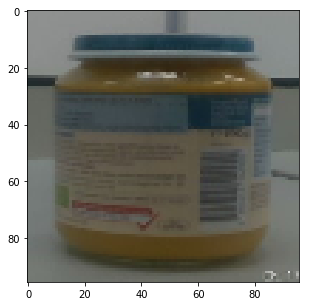

In [13]:
dataset,n = randomImages()

In [14]:
classifier(dataset,n)

INFO:tensorflow:Restoring parameters from .\Bottle
Output:  0


In [19]:
# dataset = []
# fig = plt.figure(figsize=(20,5))
# def 
#     n = 2
#     for i in range(1,n):
#         img = X_data[randint(0,len(X_data)),:,:,:]
#         fig.add_subplot(1,n-1,i)
#         plt.imshow(img)
#         plt.grid(b=None)
#         plt.tick_params(labelbottom=False,labelleft=False)
#         dataset.append(img)
#     plt.show()
#     dataset = np.array(dataset,dtype=np.float32)
#     dataset = np.dot(dataset[...,:3], rgb2gray)
#     dataset = (dataset/255-0.5)*2
#     dataset = dataset.reshape(*dataset.shape, 1)
#     return dataset,n